In [500]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [501]:
# Set the option to None to display all columns, or specify a number
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [502]:
df = pd.read_csv('output_clean_work_orders.csv', index_col='request_id')

/var/folders/lp/cttcq09s3q997sn1xwstkfjh0000gn/T/ipykernel_32270/4222864780.py:1: DtypeWarning: Columns (4,5,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('output_clean_work_orders.csv', index_col='request_id')


In [503]:
df.dtypes

created_date                      object
assigned_date                     object
response_date                     object
completion_date                   object
closed_date                       object
timezone                          object
calendar_year                      int64
fiscal_year                        int64
month                             object
day                               object
quarter                           object
days_to_complete                 float64
completion_past_due               object
property_id                       object
property_name                     object
property_active                   object
main_campus                       object
property_address                  object
property_city                     object
property_zipcode                   int64
property_state                    object
full_property_address             object
floor                              int64
property_latitude                float64
property_longitu

In [505]:
datetime_columns = ['created_date', 'assigned_date', 'response_date', 'completion_date', 'closed_date']

In [506]:
for col in datetime_columns:
    df_electrical_electrical[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [507]:
df['day'] = df['created_date'].dt.dayofweek
df['month'] = df['created_date'].dt.month
df['quarter'] = df['quarter'].str.replace('Q', '').astype(int)

In [508]:
# for col in datetime_columns:
#     df[col] = df[col].astype('int64') // 10**9
#     # Replace -9223372037 with NaN
#     df[col].replace(-9223372037, np.nan, inplace=True)


In [509]:
df.loc[df['account_string'].str[:1] == '9', 'capex_opex'] = 'capex'
df.loc[df['account_string'] != 'capex', 'capex_opex'] = 'opex'

In [510]:
#
binary_columns = ['completion_past_due', 'property_active', 'main_campus', 'status', 'billable', 'amount_exceeded', 'capex_opex']

# Define the mapping
value_mapping = {'Yes': 1, 'No': 0, 'Open': 0, 'Closed': 1, 'opex': 0, 'capex': 1}

# Apply the mapping to the specified columns
for col in binary_columns:
    if col in df.columns:
        df[col] = df[col].map(value_mapping)

In [511]:
# And columns_to_encode is a list of column names to be label encoded
columns_to_encode = ['full_property_address', 'request_type']

for col in columns_to_encode:
    # Check if the column is in the DataFrame
    if col in df.columns:
        # Create a label encoder for each column
        label_encoder = {label: idx for idx, label in enumerate(df[col].unique())}
        # Apply the label encoder
        df[f'{col}_encoded'] = df[col].map(label_encoder)


In [512]:
df = pd.concat([df, pd.get_dummies(df['request_type']).astype(int)], axis=1)

In [445]:
# Select columns that are not of 'object' dtype
non_object_columns = df.select_dtypes(exclude=['object']).columns

# From these non-object columns, further select columns that are not of 'datetime64[ns]' dtype
non_datetime_cols = df[non_object_columns].select_dtypes(exclude=['datetime64[ns]']).columns

# Keep only the non-datetime and non-object columns
df = df[non_datetime_cols]

In [446]:
df = df.dropna()

In [467]:
correlation_matrix = df.corr()

In [468]:
labor_cost_inflated_corr = correlation_matrix["labor_cost_inflated"]


In [469]:
sorted_corr = labor_cost_inflated_corr.abs().sort_values(ascending=False)

In [470]:
sorted_corr = sorted_corr[:11]

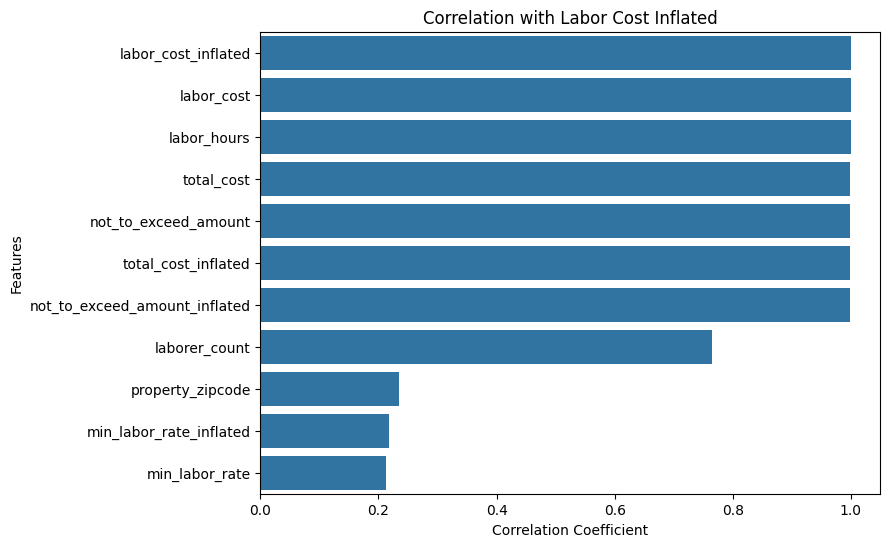

In [471]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(x=sorted_corr.values, y=sorted_corr.index)
plt.title('Correlation with Labor Cost Inflated')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()


In [513]:
import matplotlib.ticker as ticker

In [538]:
df_hvac = df.loc[df['request_type'] == 'HVAC']
df_hvac.loc[(df_hvac['employee_job_title'].str.contains('Fp')) & (~df_hvac['employee_job_title'].isna()), 'fpdc'] = 1
df_hvac.loc[df_hvac['fpdc'] != 1, 'fpdc'] = 0

/var/folders/lp/cttcq09s3q997sn1xwstkfjh0000gn/T/ipykernel_32270/4038540186.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hvac.loc[(df_hvac['employee_job_title'].str.contains('Fp')) & (~df_hvac['employee_job_title'].isna()), 'fpdc'] = 1


In [514]:
distinctive_colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown']

Laborers that are trying to stick their hours into workorders that don't make sense. IE - electrician putting down hours for a plumbing job.  People putting hours in future date. We need to have a model that iterates through subcategories and creates distros, takes 5th percentile.  ratio between materials and labor

/var/folders/lp/cttcq09s3q997sn1xwstkfjh0000gn/T/ipykernel_32270/1395674418.py:1: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(data=df_electrical,x='labor_hours',y='labor_cost_inflated', hue='fpdc', palette=distinctive_colors)


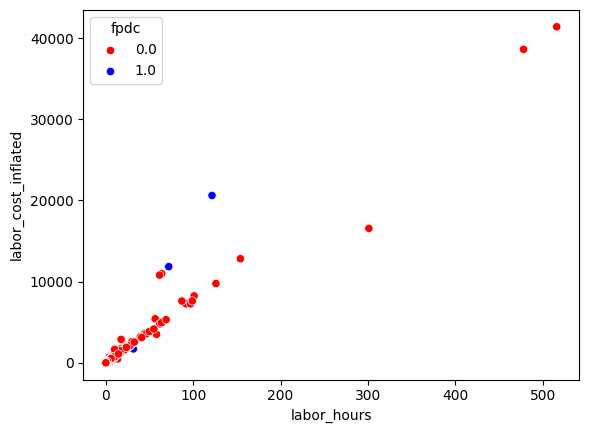

In [541]:
sns.scatterplot(data=df_electrical,x='labor_hours',y='labor_cost_inflated', hue='fpdc', palette=distinctive_colors)
# plt.ylim(top=100000)
# plt.ylim(bottom=0)
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))

In [544]:
import statsmodels.api as sm

                             OLS Regression Results                            
Dep. Variable:     labor_cost_inflated   R-squared:                       0.944
Model:                             OLS   Adj. R-squared:                  0.944
Method:                  Least Squares   F-statistic:                 3.491e+04
Date:                 Wed, 17 Jan 2024   Prob (F-statistic):               0.00
Time:                         15:03:58   Log-Likelihood:                -15204.
No. Observations:                 2070   AIC:                         3.041e+04
Df Residuals:                     2068   BIC:                         3.042e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.0065      8.396      0

/var/folders/lp/cttcq09s3q997sn1xwstkfjh0000gn/T/ipykernel_32270/2742704566.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_electrical['predicted_cost'] = model.predict(X)
/var/folders/lp/cttcq09s3q997sn1xwstkfjh0000gn/T/ipykernel_32270/2742704566.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_electrical['residuals'] = df_electrical['labor_cost_inflated'] - df_electrical['predicted_cost']
/var/folders/lp/cttcq09s3q997sn1xwstkfjh0000gn/T/ipykernel_32270/2742704566.py:22: SettingWithCopyWarni

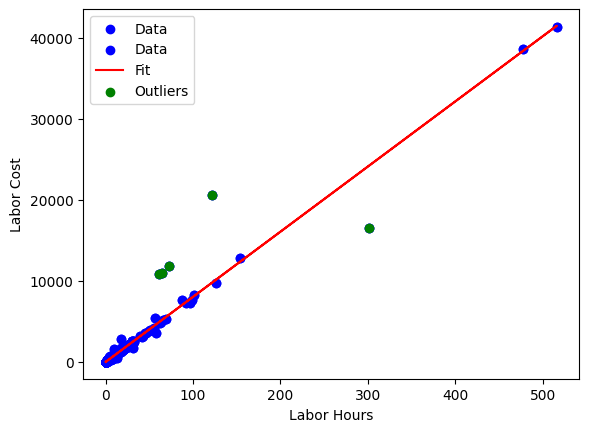

In [565]:
# Fit a linear regression model
X = df_electrical[['labor_hours']]  # Predictor
y = df_electrical['labor_cost_inflated']  # Response
X = sm.add_constant(X)  # Adds a constant term to the predictor
model = sm.OLS(y, X).fit()

# Get the summary of the regression
print(model.summary())

# Plotting the results
plt.scatter(df_electrical['labor_hours'], df_electrical['labor_cost_inflated'], c='blue', label='Data')
#plt.plot(df['labor_hours'], df_electrical['predicted_cost'], c='red', label='Fit')
# Highlight outliers

# Compute predictions
df_electrical['predicted_cost'] = model.predict(X)

# Calculate the residuals
df_electrical['residuals'] = df_electrical['labor_cost_inflated'] - df_electrical['predicted_cost']

# Calculate absolute standardized residuals
df_electrical['standardized_residuals'] = np.abs(df_electrical['residuals']) / np.std(df_electrical['residuals'])

# Detect outliers
outlier_threshold = 4
df_electrical['outlier'] = df_electrical['standardized_residuals'] > outlier_threshold

# Plotting the results
plt.scatter(df_electrical['labor_hours'], df_electrical['labor_cost_inflated'], c='blue', label='Data')
plt.plot(df_electrical['labor_hours'], df_electrical['predicted_cost'], c='red', label='Fit')
# Highlight outliers
plt.scatter(df_electrical.loc[df_electrical['outlier'], 'labor_hours'], df_electrical.loc[df_electrical['outlier'], 'labor_cost_inflated'], c='green', label='Outliers')
plt.xlabel('Labor Hours')
plt.ylabel('Labor Cost')
plt.legend()
plt.show()


In [564]:
len(df_electrical.loc[df_electrical['outlier'] == True])

7

In [504]:
df = df.loc[df['capex_opex'] != 1]a

KeyError: 'capex_opex'

In [419]:
X = df

In [420]:
scaler = StandardScaler()

In [421]:
scaled_X = scaler.fit_transform(X)

In [422]:
model = KMeans(n_clusters=2)

In [423]:
# Make sure to watch video to understand this line and fit() vs transform()
cluster_labels = model.fit_predict(scaled_X);

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [424]:
X['cluster'] = cluster_labels

In [431]:
X.loc[X['other_cost'] != 0.0]

,calendar_year,fiscal_year,month,day,quarter,days_to_complete,completion_past_due,property_active,main_campus,property_zipcode,floor,property_latitude,property_longitude,request_type_id,request_subtype_id,property_sqft,property_hours_in_day,priority,status,billable,amount_exceeded,labor_hours,labor_cost,min_labor_rate,average_labor_rate,max_labor_rate,laborer_count,labor_cost_per_hour,materials_cost,other_cost,not_to_exceed_amount,total_cost,cpi_value,labor_cost_inflated,min_labor_rate_inflated,average_labor_rate_inflated,max_labor_rate_inflated,labor_cost_per_hour_inflated,materials_cost_inflated,other_cost_inflated,not_to_exceed_amount_inflated,total_cost_inflated,capex_opex,full_property_address_encoded,request_type_encoded,Construction & Demolition,Custodial,Electrical,Elevators & Lifts,"Exterior Doors, Walls, Windows",Fire Protection,Furnishings,Grounds & Gardens,HVAC,"Interior Doors, Walls, Windows",Landscaping,Moving & Storage,Pest Control,Plumbing,Roofs,Structure & Foundation,Vehicles & Equipment,Water & Sewer,cluster
request_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
327463,2022,2023,5.0,3.0,4,28.000000,0,1,1,23185,1,37.269585,-76.714465,88,659,239075.0,9,3.0,1,1,0,3.0,211.260,70.42,70.420000,70.42,2,70.420000,0.0000,834.55,1045.8100,1045.8100,104.943619,221.703889,73.901296,73.901296,73.901296,73.901296,0.000000,875.806971,1097.510860,1097.510860,0,13,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
327469,2022,2023,5.0,3.0,4,28.000000,0,1,1,23186,1,37.271753,-76.714295,93,705,0.0,24,3.0,1,1,0,1.5,76.875,43.93,51.250000,54.91,3,51.250000,0.0000,72.00,148.8750,148.8750,104.943619,80.675407,46.101732,53.783605,57.624541,53.783605,0.000000,75.559406,156.234812,156.234812,0,9,6,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
327472,2022,2023,5.0,3.0,4,28.000000,1,1,1,23185,1,37.274536,-76.717688,89,665,8244.0,9,3.0,1,1,0,3.0,225.000,75.00,75.000000,75.00,1,75.000000,0.0000,6351.07,6576.0700,6576.0700,104.943619,236.123142,78.707714,78.707714,78.707714,78.707714,0.000000,6665.042690,6901.165833,6901.165833,0,101,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
327493,2022,2023,5.0,3.0,4,28.000000,0,1,1,23185,-1,37.269846,-76.716089,87,1337,259065.0,9,3.0,1,1,0,4.0,293.790,70.86,72.516000,75.00,1,73.447500,0.0000,10650.50,10944.2900,10944.2900,104.943619,308.313858,74.363048,76.100915,78.707714,77.078464,0.000000,11177.020120,11485.333978,11485.333978,0,8,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
327521,2022,2023,5.0,4.0,4,28.000000,0,1,1,23185,1,37.273269,-76.709075,87,649,4119.0,24,3.0,1,1,0,30.0,2271.480,70.42,76.207143,88.03,6,75.716000,72.0459,1555.13,3898.6559,3898.6559,104.943619,2383.773312,73.901296,79.974533,92.381868,79.459110,75.607575,1632.009699,4091.390586,4091.390586,0,194,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371930,2023,2024,12.0,1.0,2,3.000000,0,1,1,23185,1,37.269309,-76.709819,87,651,3018.0,9,2.0,0,1,0,18.0,1500.000,75.00,81.818182,112.50,5,83.333333,0.0000,133.00,1633.0000,1633.0000,100.000000,1500.000000,75.000000,81.818182,112.500000,83.333333,0.000000,133.000000,1633.000000,1633.000000,0,79,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
372084,2023,2024,12.0,4.0,2,12.715370,0,1,1,23185,1,37.272962,-76.712441,87,1115,0.0,9,3.0,0,1,0,32.0,3037.500,75.00,88.636364,112.50,5,94.921875,0.0000,38.57,3076.0700,3076.0700,100.000000,3037.500000,75.000000,88.636364,112.500000,94.921875,0.000000,38.570000,3076.070000,3076.070000,0,51,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
319472,2024,2025,1.0,0.0,3,10.666655,0,1,1,23185,1,37.269585,-76.714465,117,1397,239075.0,9,3.0,0,1,0,3.5,262.500,75.00,75.000000,75.00,2,75.000000,0.0000,4235.16,4497.6600,4497.6600,100.000000,262.500000,75.000000,75.000000,75.000000,75.000000,0.000000,4235.160000,4497.660000,4497.660000,0,13,2,0,

In [425]:
X.corr()['cluster'].abs().sort_values(ascending=False)[2:]

labor_cost                        0.940107
labor_cost_inflated               0.940019
not_to_exceed_amount              0.938260
total_cost                        0.938260
not_to_exceed_amount_inflated     0.938168
total_cost_inflated               0.938168
laborer_count                     0.697702
min_labor_rate_inflated           0.182893
property_zipcode                  0.181604
min_labor_rate                    0.178545
property_hours_in_day             0.111586
average_labor_rate_inflated       0.082825
labor_cost_per_hour_inflated      0.082313
average_labor_rate                0.081399
labor_cost_per_hour               0.080924
max_labor_rate_inflated           0.073101
max_labor_rate                    0.072034
Custodial                         0.055793
day                               0.049317
request_type_id                   0.047195
property_sqft                     0.036398
full_property_address_encoded     0.033661
status                            0.029473
fiscal_year

<Axes: >

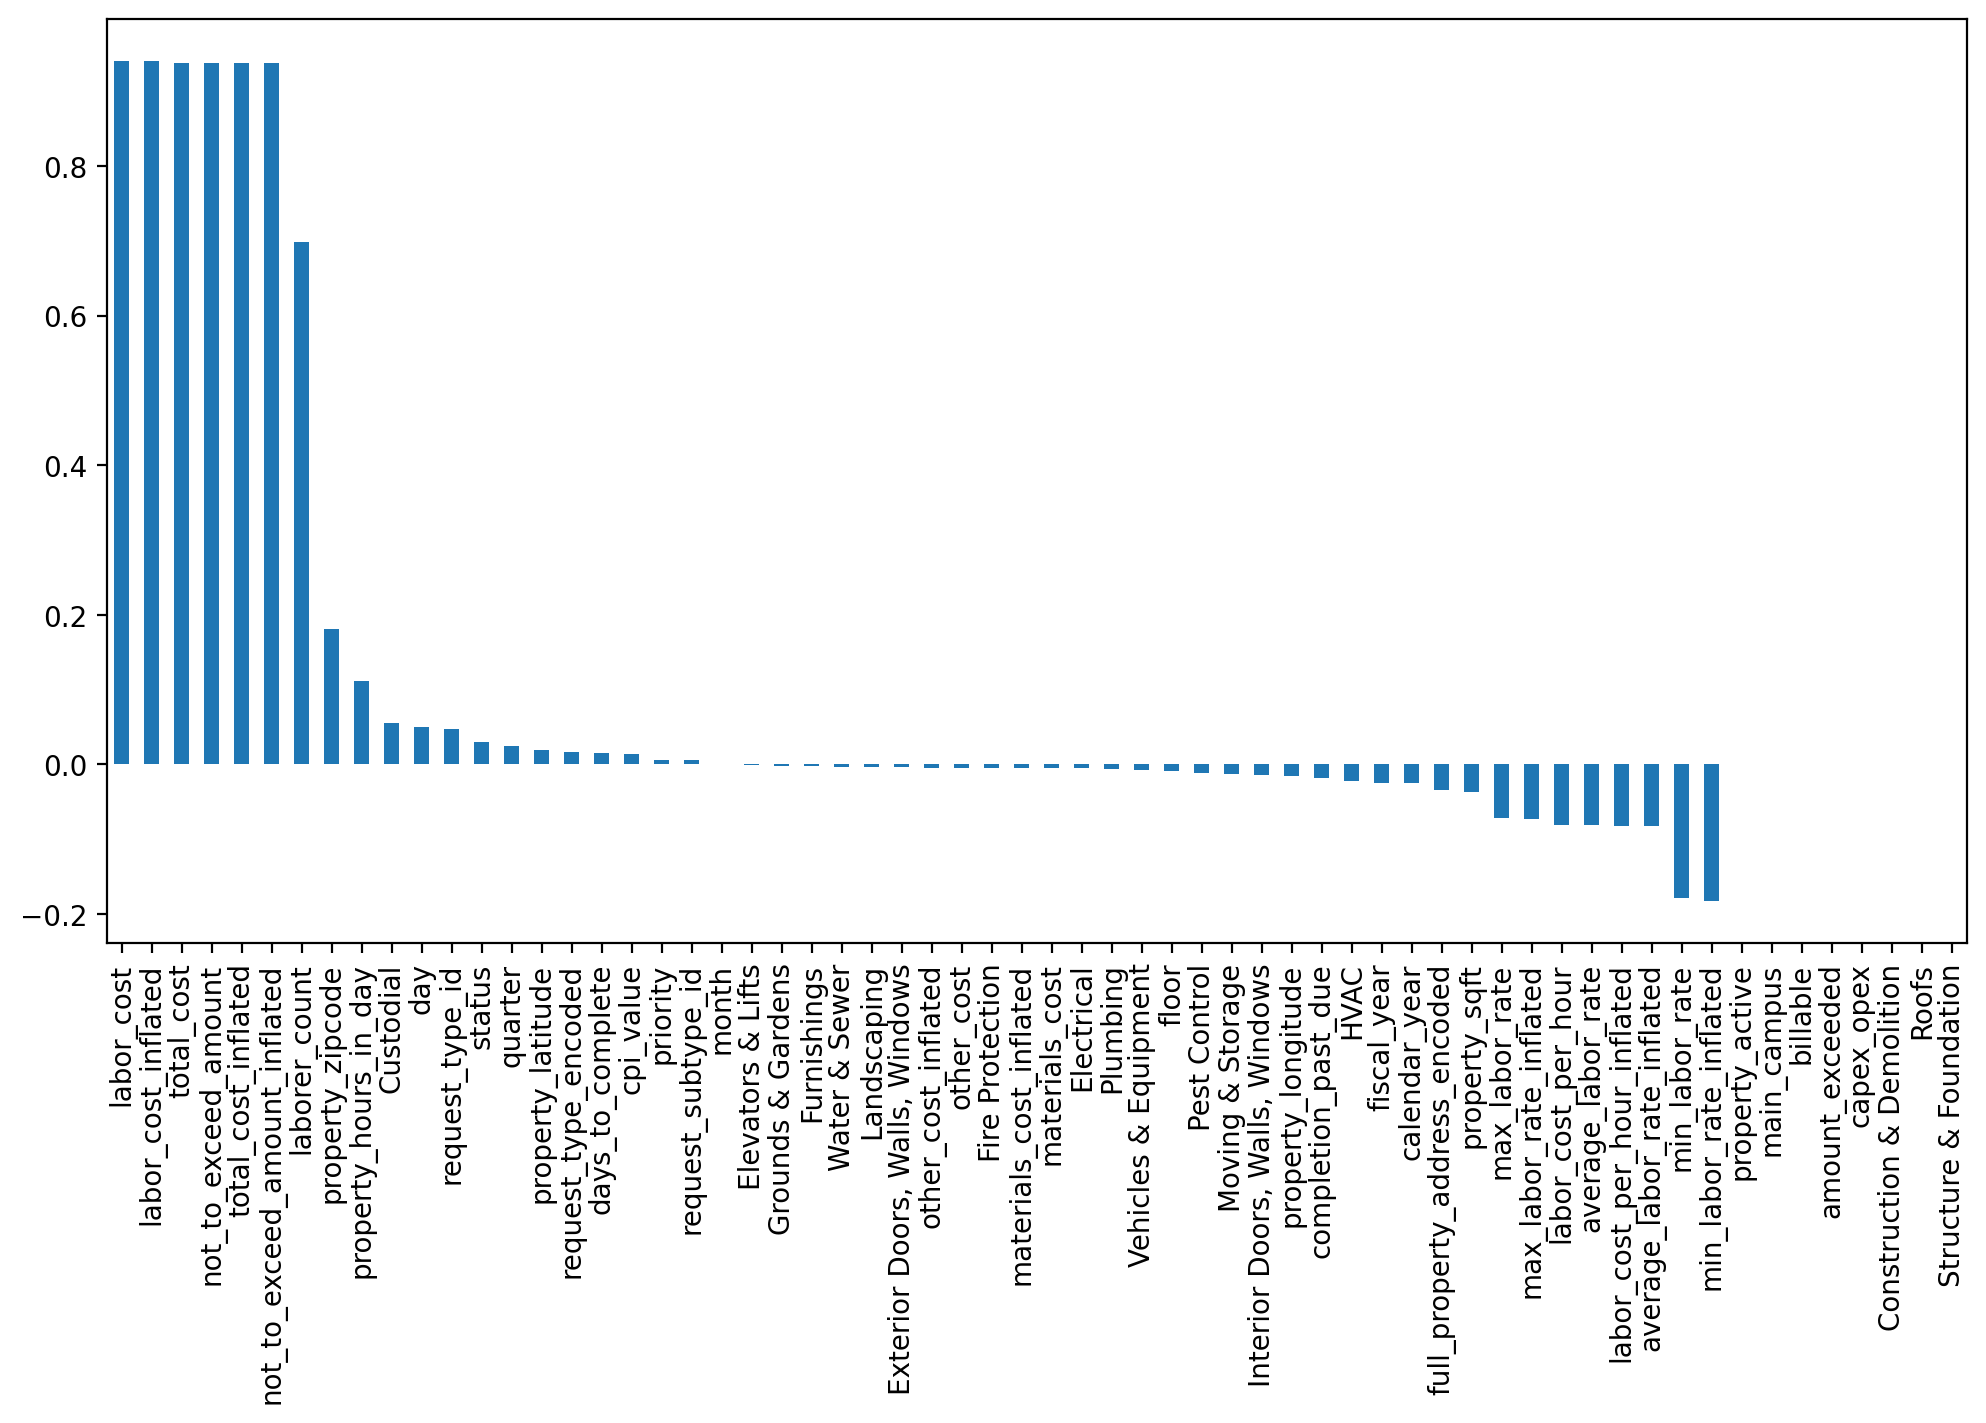

In [426]:
plt.figure(figsize=(12,6),dpi=200)
X.corr()['cluster'].sort_values(ascending=False)[2:].plot(kind='bar')

In [357]:
ssd = []

for k in range(2,10):
    
    model = KMeans(n_clusters=k)
    
    
    model.fit(scaled_X)
    
    #Sum of squared distances of samples to their closest cluster center.
    ssd.append(model.inertia_)

/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/homebrew/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

Text(0, 0.5, ' Sum of Squared Distances')

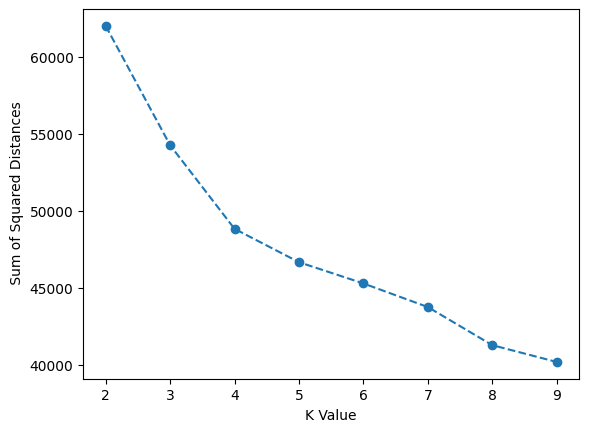

In [358]:
plt.plot(range(2,10),ssd,'o--')
plt.xlabel("K Value")
plt.ylabel(" Sum of Squared Distances")

<Axes: >

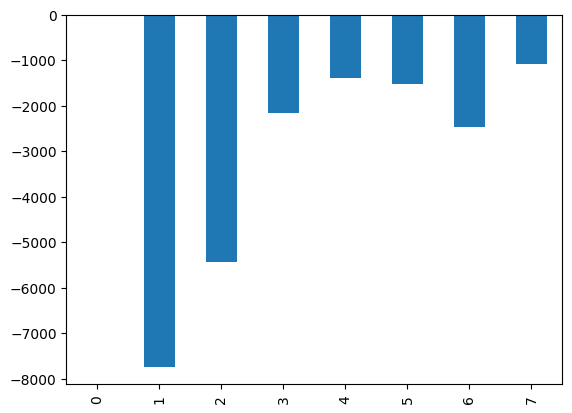

In [359]:
pd.Series(ssd).diff().plot(kind='bar')